# Investigating the correlation between plant pairs (related by genus) and their geolocation 

### Import modules

In [1]:
import logging
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm
    
# Stats
from statannot import add_stat_annotation

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
logging.disable()
pd.options.mode.chained_assignment = None

In [4]:
DATA_DIR = '../data/processed'
MAPPING_DIR = '../data/mapping'

### Load plant-disease evidences

In [5]:
literature_pairs = pd.read_csv(
    f'{DATA_DIR}/literature_based_correlation_data.tsv',
    sep='\t'
)

literature_pairs_genus = literature_pairs[literature_pairs['pair_type'] == 'Same genus']
literature_pairs_genus.shape

(10962, 4)

In [6]:
database_pairs = pd.read_csv(
    f'{DATA_DIR}/database_based_correlation_data.tsv',
    sep='\t'
)

database_pairs_genus = database_pairs[database_pairs['pair_type'] == 'Same genus']
database_pairs_genus.shape

(3533, 4)

In [7]:
medicinal_plants_lit = set(literature_pairs_genus['plant_1'].tolist()).union(
    literature_pairs_genus['plant_2'].tolist()
)

medicinal_plants_database = set(database_pairs_genus['plant_1'].tolist()).union(
    database_pairs_genus['plant_2'].tolist()
)

medicinal_plants = medicinal_plants_lit.union(medicinal_plants_database)

len(medicinal_plants)

4004

### Loading plant location data

In [8]:
ncbi_ids_trefle = json.load(open(f'{MAPPING_DIR}/trefle_grounding.json'))

In [9]:
trefle_df = pd.read_csv(
    '../data/raw/trefle_species_dump.csv', 
    sep='\t', 
    usecols=['scientific_name', 'distributions']
)

In [10]:
trefle_df['scientific_name'] = trefle_df['scientific_name'].str.replace('?', '')
trefle_df['ncbi_ids'] = trefle_df['scientific_name'].map(lambda x: ncbi_ids_trefle[x][0])
trefle_df = trefle_df[trefle_df['ncbi_ids'].isin(medicinal_plants)]
trefle_df.head(3)

/var/folders/61/bn_r735d70z03hg56wh7hsg80000gn/T/ipykernel_11379/105416592.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  trefle_df['scientific_name'] = trefle_df['scientific_name'].str.replace('?', '')


,scientific_name,distributions,ncbi_ids
0,Abies balsamea,"Alberta,Connecticut,Iowa,Labrador,Maine,Manito...",ncbitaxon:90345
4,Abies grandis,"British Columbia,California,Idaho,Montana,Oreg...",ncbitaxon:46611
29,Abutilon theophrasti,"Thailand,China North-Central,China South-Centr...",ncbitaxon:3631


In [11]:
geolocation_data = pd.read_csv(
    f'{DATA_DIR}/plant_geolocation.tsv', sep='\t', 
    index_col='Plant location (trefle)',
    usecols=['Plant location (trefle)', 'Country']
)
geolocation_data = geolocation_data[geolocation_data['Country'] != '-']

In [12]:
location_info = geolocation_data.to_dict()['Country']
len(location_info)

308

### Create location dictionary

In [13]:
def get_geolocation_dict(location_based_df: pd.DataFrame, loc_info: dict):
    """Method to get plant-location based dictionary."""
    plant_loc_data = defaultdict(set)
    skip = set()

    for _, locations, ncbi_ids in tqdm(location_based_df.values):
        if pd.isna(locations):
            continue
        for loc_name in locations.split(','):
            if loc_name not in loc_info:
                skip.add(loc_name)
                continue
            plant_loc_data[ncbi_ids].add(loc_info[loc_name])

    return plant_loc_data, skip

In [14]:
plant_loc_data, skipped_plants = get_geolocation_dict(trefle_df, location_info)
len(plant_loc_data), len(skipped_plants)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5223/5223 [00:00<00:00, 45035.24it/s]


(3155, 59)

The locations that have been skipped in the previous step correspond to Islands.

### Correlation plot

In [15]:
def calculate_overlap_coefficient(elements_in_plant_1, elements_in_plant_2):
    """Calculate coeffiencient overlap."""
    if not elements_in_plant_1 or not elements_in_plant_2:
        return 0
    
    return len(
        elements_in_plant_1.intersection(elements_in_plant_2)
    ) / min([len(elements_in_plant_1), len(elements_in_plant_2)])


def get_graph_df(df):
    rows = []

    for plant1, plant2, _, coeff in tqdm(df.values):
        if plant1 not in plant_loc_data or plant2 not in plant_loc_data:
            continue

        loc_plant_1 = plant_loc_data[plant1]
        loc_plant_2 = plant_loc_data[plant2]
        overlap_coeff = calculate_overlap_coefficient(loc_plant_1, loc_plant_2)

        if overlap_coeff == 0:
            overlap_score = 'No overlap'
        elif overlap_coeff < 0.3:
            overlap_score = 'Low'
        elif 0.3 < overlap_coeff < 0.6:
            overlap_score = 'Medium'
        else:
            overlap_score = 'High'

        rows.append({
            'plant_1': plant1, 
            'plant_2': plant2,
            'Geographical similarity (country overlap)': overlap_score, 
            'pearson_coefficient': coeff,
        })
 
    return pd.DataFrame(rows)

In [16]:
literature_merged = get_graph_df(literature_pairs_genus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10962/10962 [00:00<00:00, 266048.45it/s]


In [17]:
database_merged = get_graph_df(database_pairs_genus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3533/3533 [00:00<00:00, 299987.37it/s]


In [18]:
literature_merged.head()

,plant_1,plant_2,Geographical similarity (country overlap),pearson_coefficient
0,ncbitaxon:192627,ncbitaxon:154765,Low,NaN
1,ncbitaxon:192627,ncbitaxon:35872,Medium,0.690849
2,ncbitaxon:192627,ncbitaxon:173850,Low,0.690849
3,ncbitaxon:192627,ncbitaxon:281397,No overlap,NaN
4,ncbitaxon:154765,ncbitaxon:35872,High,-0.045455


In [19]:
database_merged.head()

,plant_1,plant_2,Geographical similarity (country overlap),pearson_coefficient
0,ncbitaxon:4543,ncbitaxon:1643560,High,0.322329
1,ncbitaxon:180498,ncbitaxon:3996,High,0.935049
2,ncbitaxon:180498,ncbitaxon:454931,High,0.852168
3,ncbitaxon:180498,ncbitaxon:454930,High,0.935049
4,ncbitaxon:3996,ncbitaxon:454931,High,0.796819


### Plots

In [20]:
sns.set(context='poster')
mpl.rcParams['figure.dpi'] = 400

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. Medium: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.269e-01 U_stat=2.813e+05
No overlap v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.403e-14 U_stat=2.046e+06
Low v.s. No overlap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.970e-01 U_stat=6.172e+05
Medium v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.351e-02 U_stat=1.114e+06


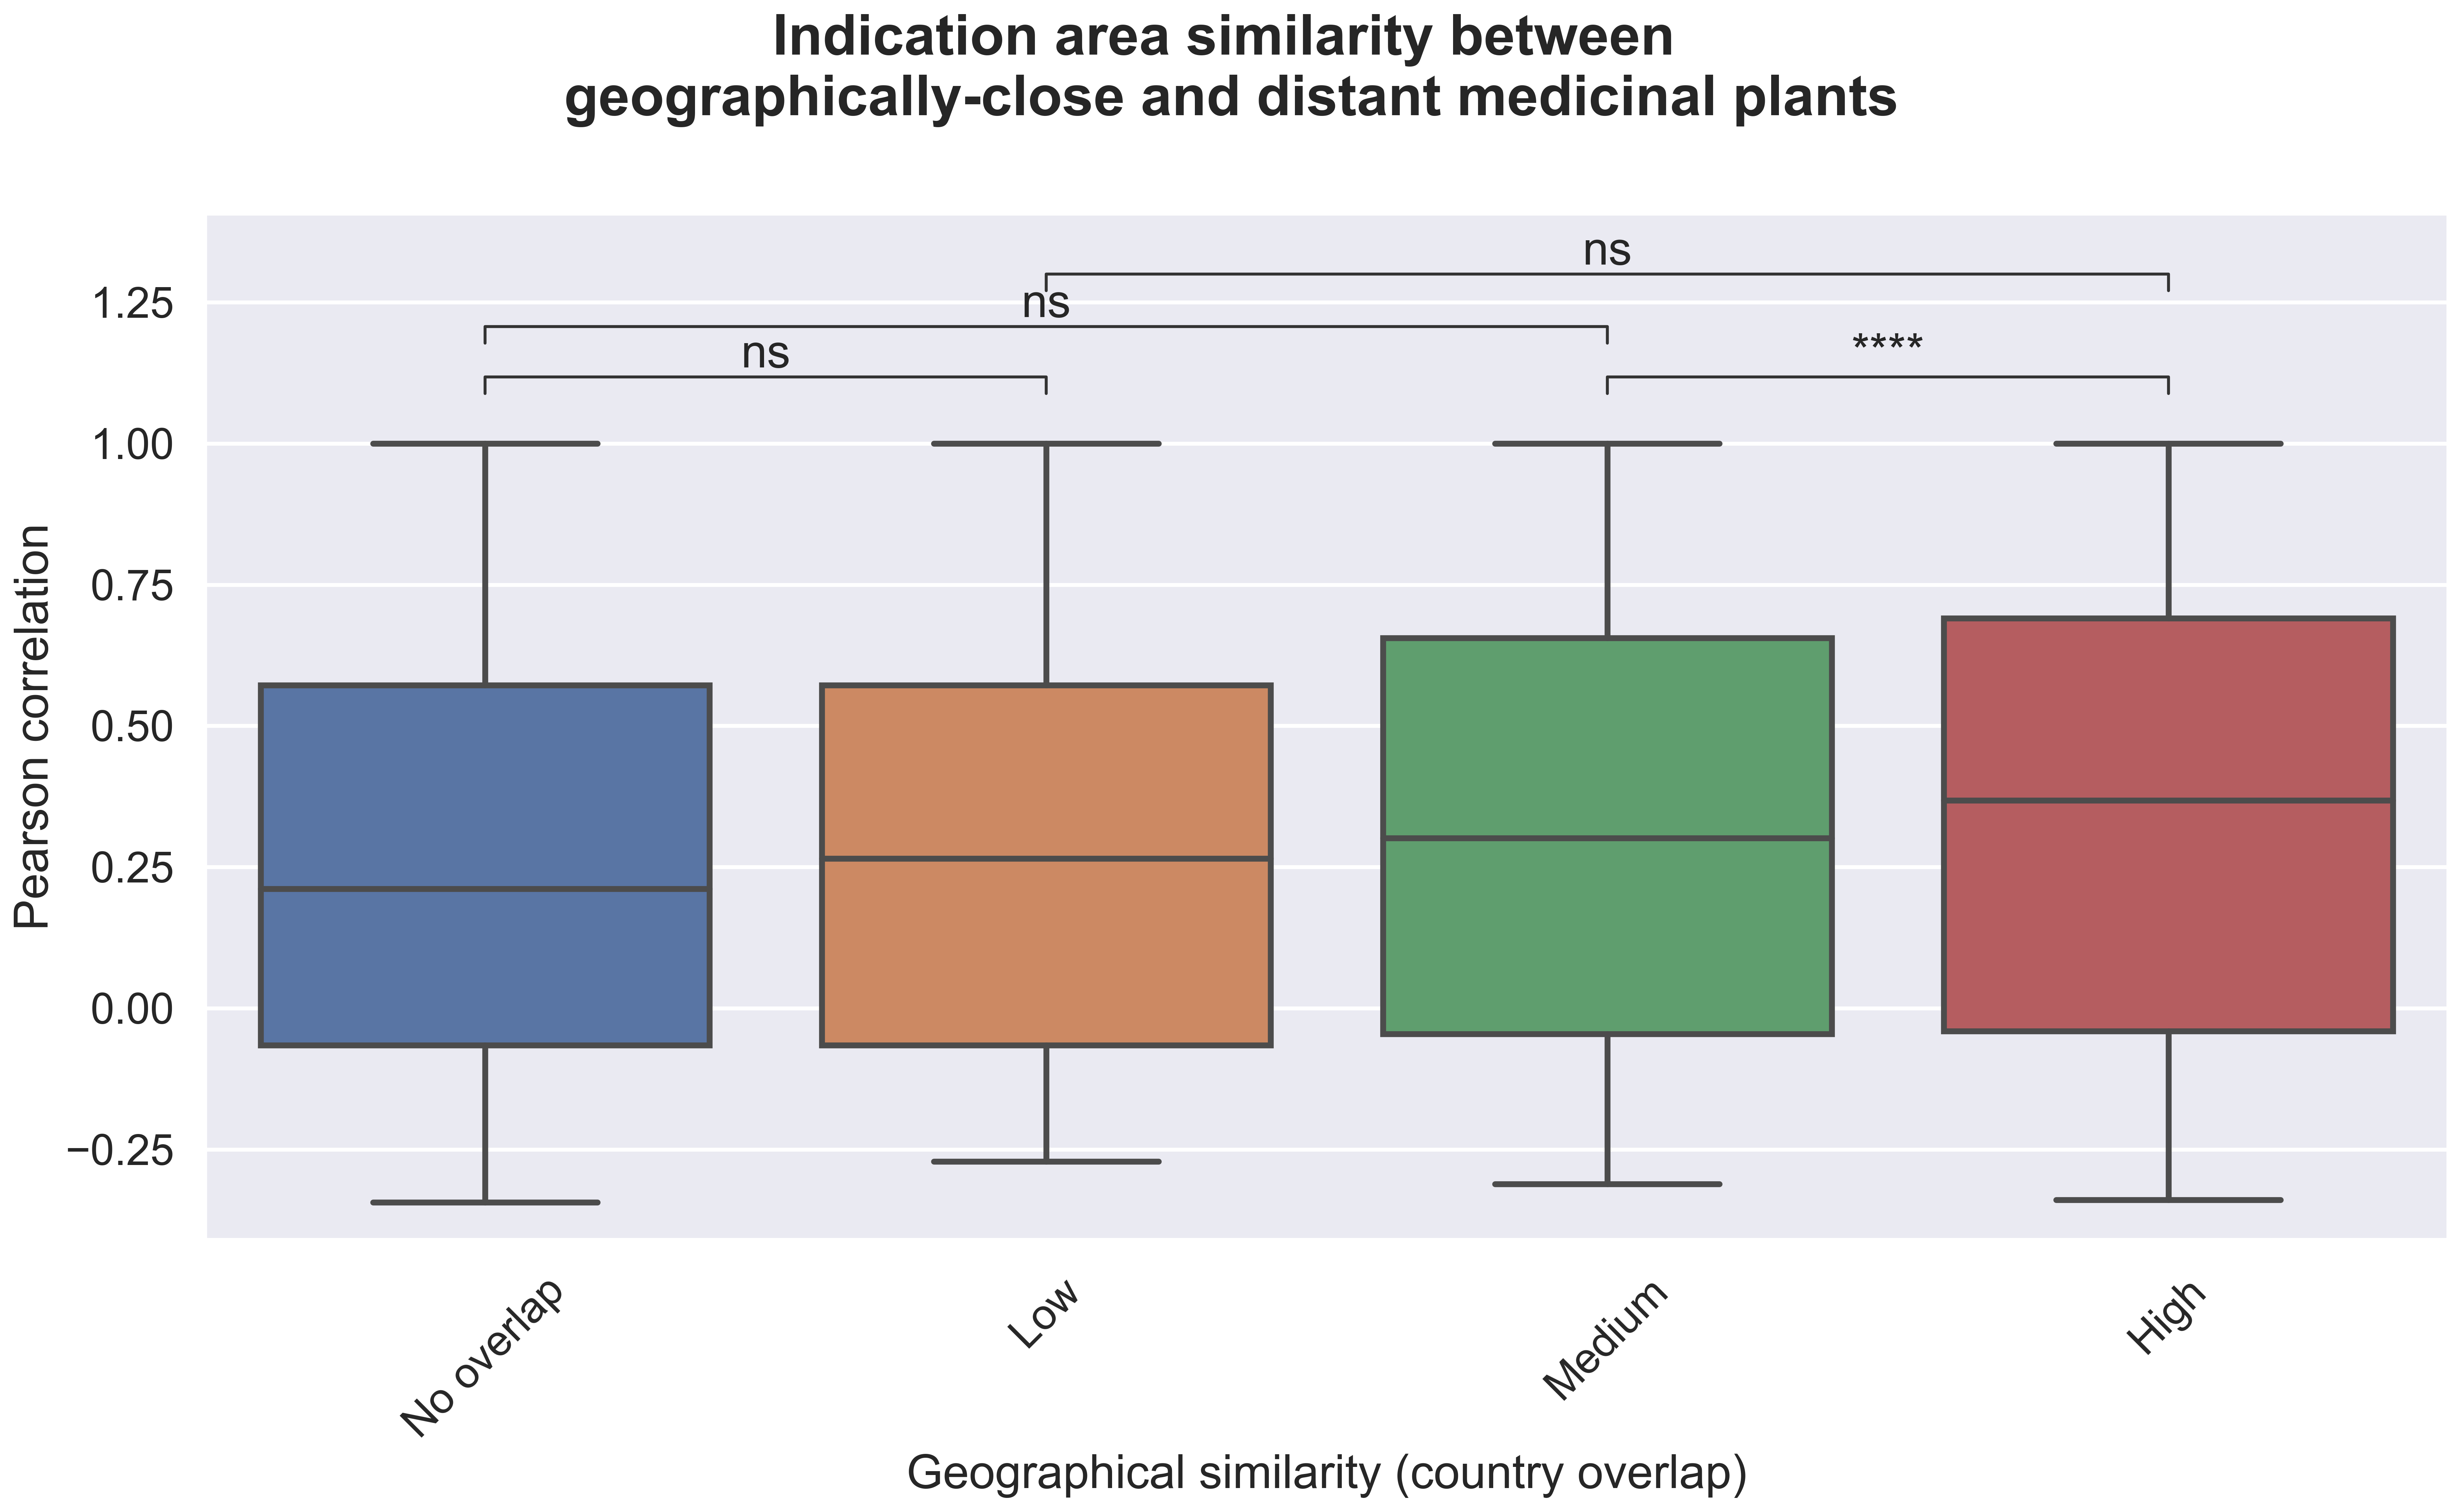

In [21]:
fig = plt.figure(figsize=(18, 11)) 
ax1 = fig.add_subplot(111)

suptitle = plt.suptitle(
    'Indication area similarity between \ngeographically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold'
)

sns.boxplot(
    data=literature_merged, x='Geographical similarity (country overlap)', y='pearson_coefficient', ax=ax1,
    order=['No overlap', 'Low', 'Medium', 'High'],
)
add_stat_annotation(
    data=literature_merged,
    x='Geographical similarity (country overlap)',
    y='pearson_coefficient',
    ax=ax1,
    box_pairs=[
        ("No overlap", "Low"), ("Low", "Medium"), 
        ("Medium", "High"), ("No overlap", "High")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Set Y and X ticks
ax1.set_ylabel("Pearson correlation")
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/figure_3.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()

#### Supplementary figure

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Low v.s. No overlap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.673e+04
Medium v.s. Low: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.128e+04
High v.s. Medium: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.255e-05 U_stat=2.161e+05
High v.s. No overlap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.488e-03 U_stat=1.668e+05


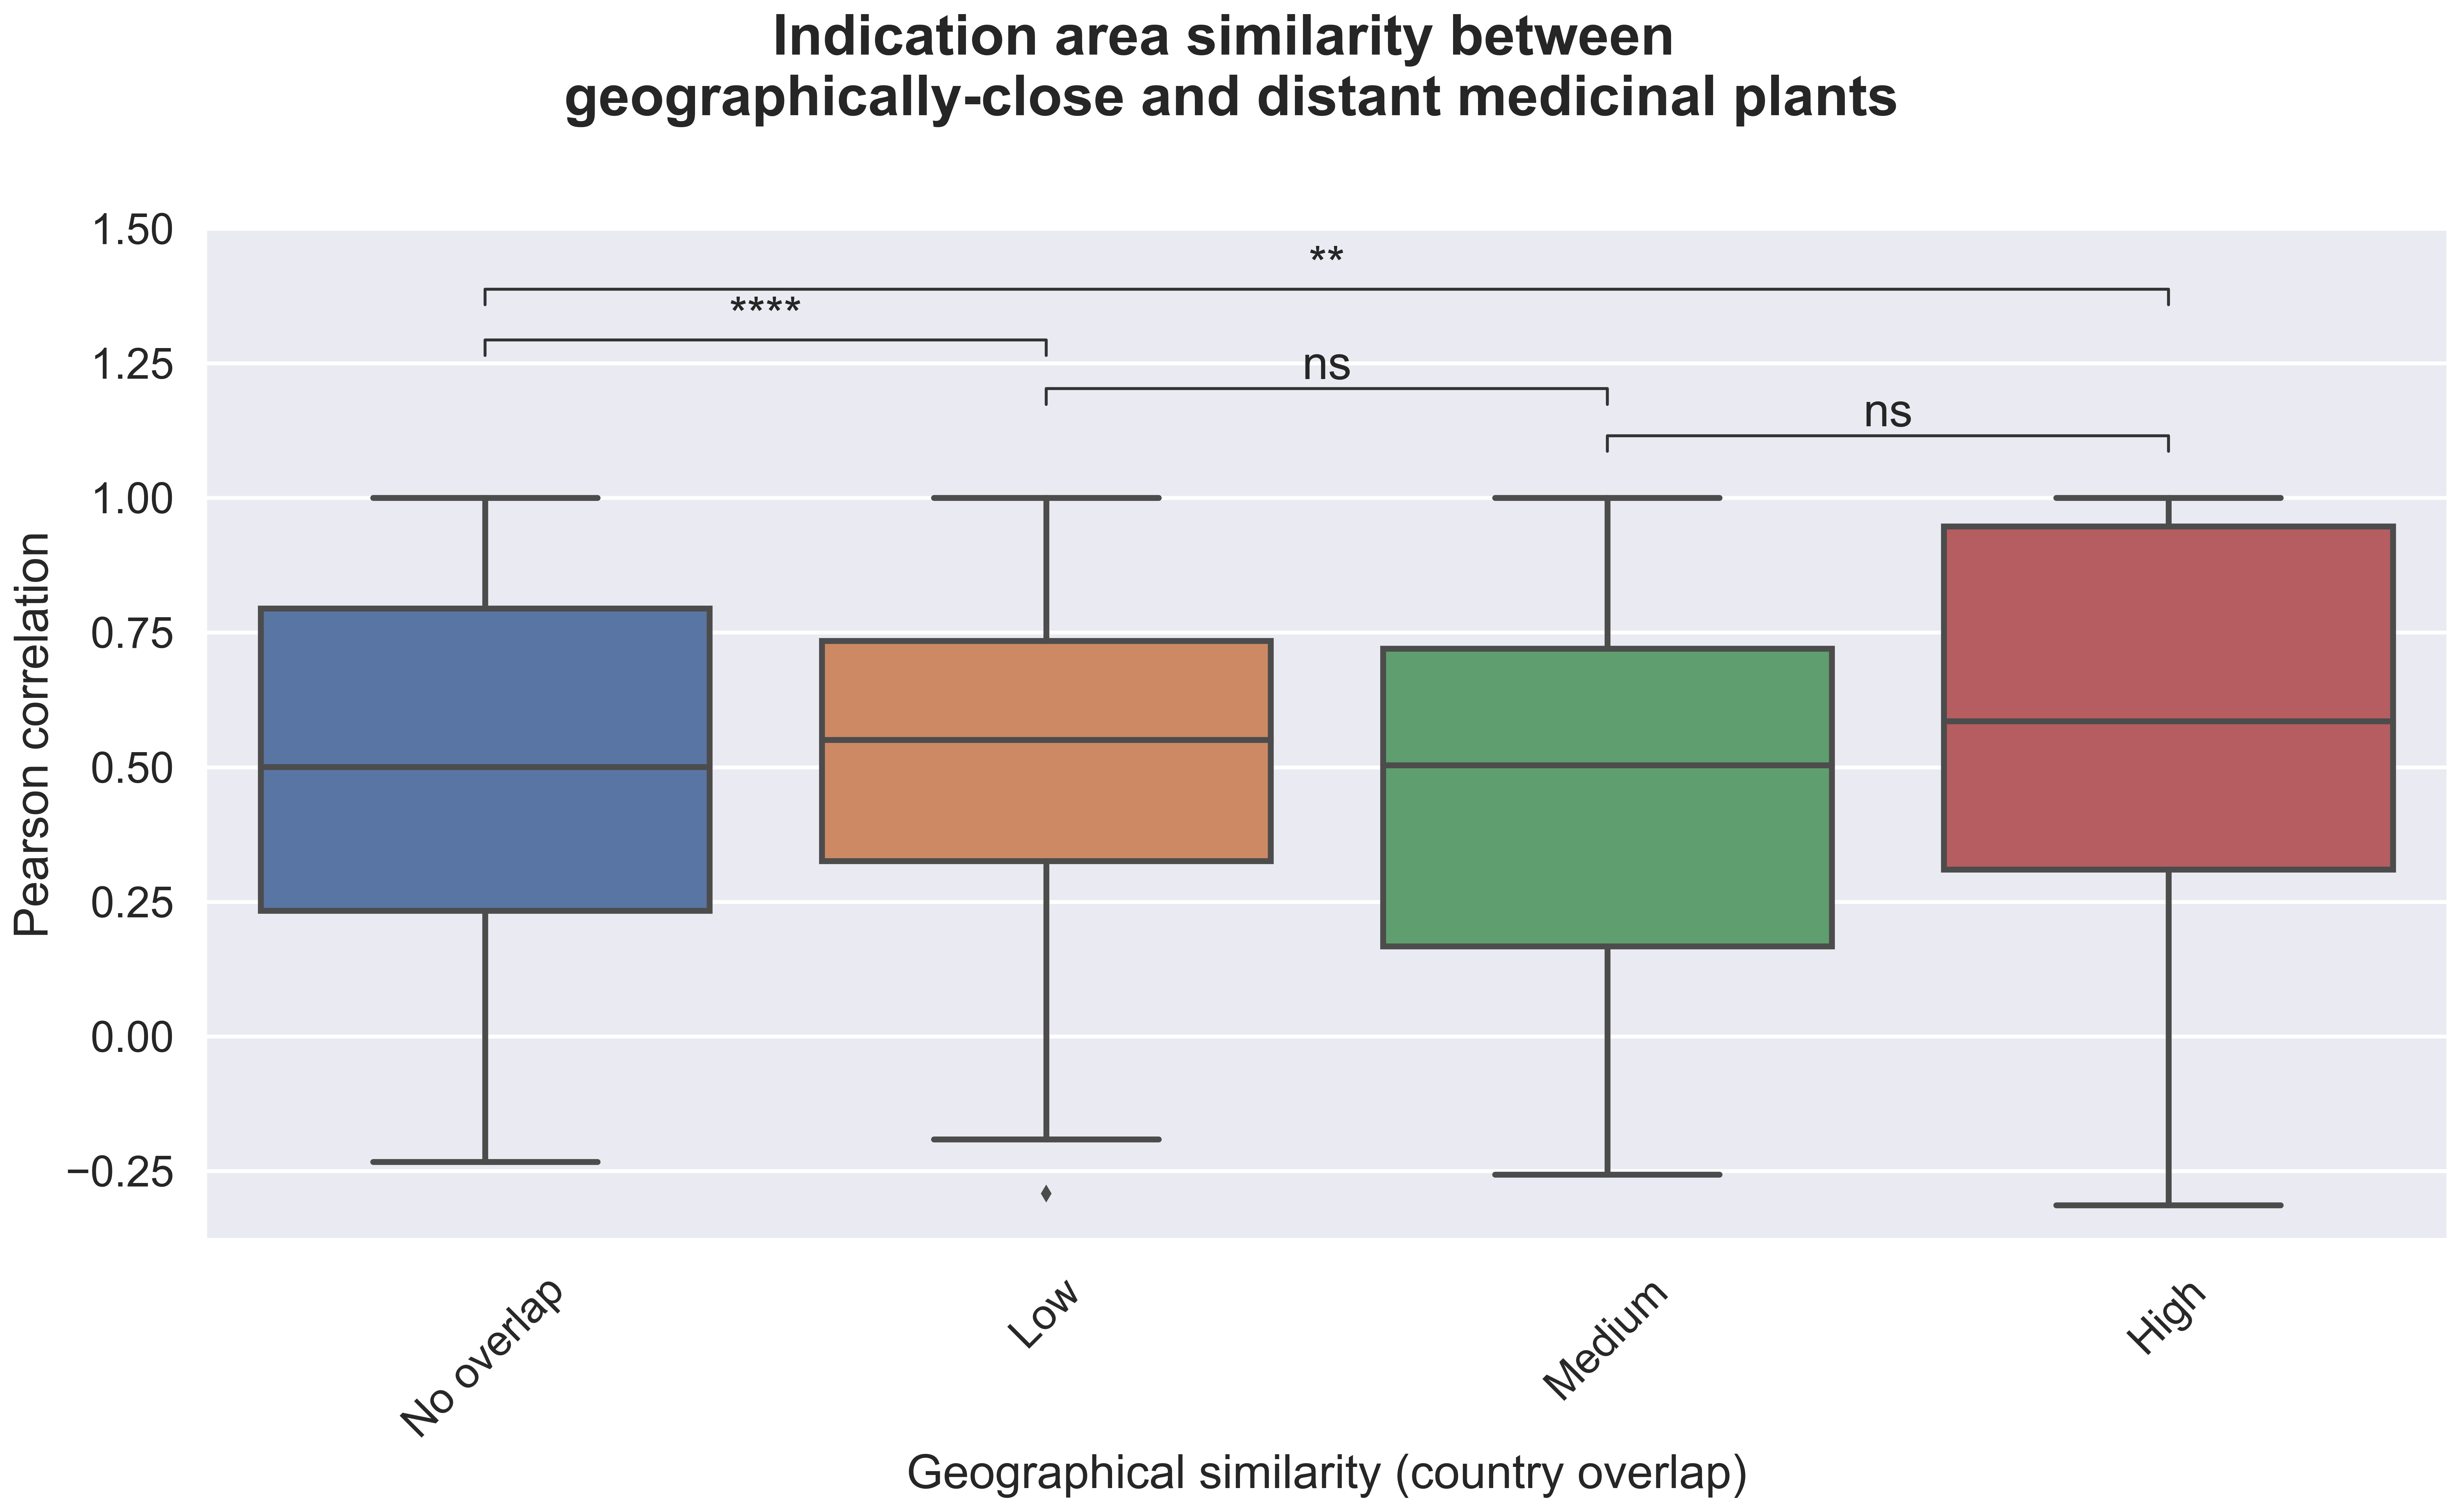

In [22]:
fig = plt.figure(figsize=(18, 11)) 
ax1 = fig.add_subplot(111)

suptitle = plt.suptitle(
    'Indication area similarity between \ngeographically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold'
)
# 
sns.boxplot(
    data=database_merged, x='Geographical similarity (country overlap)', y='pearson_coefficient', ax=ax1,
    order=['No overlap', 'Low', 'Medium', 'High'],
)
add_stat_annotation(
    data=database_merged,
    x='Geographical similarity (country overlap)',
    y='pearson_coefficient',
    ax=ax1,
    box_pairs=[
        ("No overlap", "Low"), ("Low", "Medium"), 
        ("Medium", "High"), ("No overlap", "High")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Set Y and X ticks
ax1.set_ylabel("Pearson correlation")
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/supplementary_figure_4.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()